## Logistic Regression
This notebook runs the drug repurposing project's first model, logistic regression. Run all 50 assays, first part would be creating the predictive logistic regression for each assay, and save feature coefficients. We'll use the statistic logistic regression model to look at specific uncommon features' p-value/std error

### Predictive models

In [ ]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import Lasso

import pymc as pm
import arviz as az

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

# Set working directory
path = '/content/drive/My Drive/Tox21_data/'

Mounted at /content/drive


In [ ]:
xls = pd.ExcelFile(path + 'Tox21/assay_list.xls')

# Now you can list all sheets in the file
xls.sheet_names

# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

len(df)


22

In [ ]:
xls2 = pd.ExcelFile(path + 'Tox21/assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)



50

In [ ]:
# LASSO
# logistic_cv_unbalanced = LogisticRegressionCV(penalty='l1',Cs=10,max_iter=10000,class_weight=None, solver = 'saga').fit(X_train, y_train)
# logistic_cv_balanced = LogisticRegressionCV(penalty='l1',Cs=10,max_iter=10000,class_weight='balanced', solver = 'saga').fit(X_train, y_train)
logistic_cv_unbalanced = LogisticRegressionCV(penalty='l1',class_weight=None, solver = 'saga').fit(X_train, y_train)
logistic_cv_balanced = LogisticRegressionCV(penalty='l1',class_weight='balanced', solver = 'saga').fit(X_train, y_train)


/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3

/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/pymc_env/lib/python3

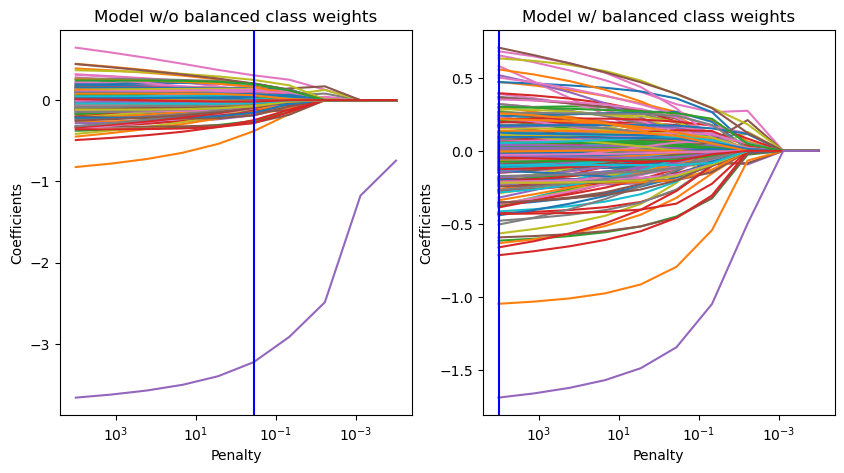

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax.plot(logistic_cv_unbalanced.Cs_, logistic_cv_unbalanced.coefs_paths_[1].mean(axis=0))
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
ax.set_xlabel("Penalty")
ax.set_ylabel("Coefficients")
ax.set_title("Model w/o balanced class weights")

ax1.plot(logistic_cv_balanced.Cs_, logistic_cv_balanced.coefs_paths_[1].mean(axis=0))
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x =logistic_cv_balanced.C_, color = 'b', label = 'axvline - full height')
ax1.set_xlabel("Penalty")
ax1.set_ylabel("Coefficients")
ax1.set_title("Model w/ balanced class weights")


plt.show()

### Run all 50 assays

In [ ]:
label_encoder = preprocessing.LabelEncoder()
# coefs = []
coefs_w = []
# bal_accs = []
bal_accs_w = []
# auc_scores = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []
bal_accs_t = []
auc_scores_t = []
lambda_sig_w = []
recalls_t = []
f1s_t = []
precisions_t = []

# feature_top_40 = ['Chi4v', 'SMR_VSA4', 'EState_VSA5', 'SlogP_VSA10', 'EState_VSA8',
#                   'Kappa3', 'fr_Al_COO', 'SlogP_VSA8', 'PEOE_VSA10', 'fr_amide',
#                   'PEOE_VSA14', 'VSA_EState10', 'FractionCSP3', 'PEOE_VSA4',
#                   'VSA_EState9', 'VSA_EState3', 'MolLogP', 'VSA_EState7', 'BalabanJ',
#                   'fr_ketone_Topliss', 'fr_methoxy', 'MaxAbsPartialCharge',
#                   'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
#                   'MinAbsEStateIndex', 'fr_ester', 'fr_bicyclic', 'SlogP_VSA3',
#                   'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'fr_aniline', 'fr_para_hydroxylation',
#                   'EState_VSA2', 'VSA_EState4', 'EState_VSA9', 'PEOE_VSA9', 'SlogP_VSA1',
#                   'SlogP_VSA12', 'TPSA']

feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
                  'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
                  'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
                  'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
                  'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
                  'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
                  'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
                  'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
                  'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO']
for j in range(5):
  for i in range(len(df)):
      one_assay = df[i]
      one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates(subset = 'SMILES')
      # print(one_assay)
      y = label_encoder.fit_transform(one_assay.iloc[:,0])
      # print(y)
      X = one_assay[one_assay.columns.intersection(feature_top_40)]
      # print(X)
      scaler = StandardScaler()
      # X = scaler.transform(one_assay.iloc[:,2:])
      # y = label_encoder.fit_transform(one_assay.iloc[:,0])
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state = j)
      near_miss = RandomUnderSampler(random_state = j)  #NearMiss(version = 1, n_neighbors = 3)
      X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train,y_train)
      print(Counter(y_train_resampled))
      print(Counter(y_train))
      X_train = scaler.fit_transform(X_train_resampled)
      X_test = scaler.transform(X_test)
      # logistic_cv_unbalanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight=None).fit(X_train, y_train)
      logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,
                                                  max_iter=10000,class_weight=None).fit(X_train, y_train_resampled)

      # coef = logistic_cv_unbalanced.coef_[0]
      # coefs.append(coef)

      coef_w = logistic_cv_balanced.coef_[0]
      coefs_w.append(coef_w)

      # ax = plt.gca()
      # fig.set_size_inches(10, 5)

      # ax.plot(logistic_cv_balanced.Cs_, logistic_cv_balanced.coefs_paths_[1].mean(axis=0))
      # ax.set_xscale("log")
      # ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
      # ax.axvline(x =logistic_cv_unbalanced.C_, color = 'b', label = 'axvline - full height')
      # ax.set_xlabel("Penalty")
      # ax.set_ylabel("Coefficients")
      # ax.set_title("Model w balanced class weights")
      # plt.show()

      # y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
      y_train_pred = logistic_cv_balanced.predict(X_train)
      y_pred_balanced = logistic_cv_balanced.predict(X_test)

      # y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
      y_train_pred_prob = logistic_cv_balanced.predict_proba(X_train)[:,1]
      y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

      # print(one_assay.columns[0])
      # print(classification_report(y_test,y_pred_balanced))

      # bal_acc = balanced_accuracy_score(y_test,y_pred_unbalanced)
      # bal_accs.append(bal_acc)

      bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
      bal_acc_t = balanced_accuracy_score(y_train_resampled,y_train_pred)


      # auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
      # auc_scores.append(auc_score)

      auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
      auc_score_t = metrics.roc_auc_score(y_train_resampled, y_train_pred_prob)


      recall_score = metrics.recall_score(y_test, y_pred_balanced)
      recall_t = metrics.recall_score(y_train_resampled,y_train_pred)


      f1_score = metrics.f1_score(y_test, y_pred_balanced)
      f1_t = metrics.f1_score(y_train_resampled,y_train_pred)

      precision_score = metrics.precision_score(y_test, y_pred_balanced)
      precision_t = metrics.precision_score(y_train_resampled,y_train_pred)

      # lambda_sig = logistic_cv_balanced.C_
      # lambda_sig_w.append(lambda_sig)
      bal_accs_w.append(bal_acc_w)
      auc_scores_w.append(auc_score_w)
      recall_scores.append(recall_score)
      recalls_t.append(recall_t)
      f1_scores.append(f1_score)
      f1s_t.append(f1_t)
      precision_scores.append(precision_score)
      precisions_t.append(precision_t)
      bal_accs_t.append(bal_acc_t)
      auc_scores_t.append(auc_score_t)
  print(len(auc_scores_t))
  print(j)


Counter({0: 480, 1: 480})
Counter({0: 5659, 1: 480})
Counter({0: 319, 1: 319})
Counter({0: 5596, 1: 319})
Counter({0: 594, 1: 594})
Counter({0: 5460, 1: 594})
Counter({0: 661, 1: 661})
Counter({0: 5242, 1: 661})
Counter({0: 514, 1: 514})
Counter({0: 5744, 1: 514})
Counter({0: 444, 1: 444})
Counter({0: 5599, 1: 444})
Counter({0: 427, 1: 427})
Counter({0: 5139, 1: 427})
Counter({0: 717, 1: 717})
Counter({0: 5374, 1: 717})
Counter({0: 540, 1: 540})
Counter({0: 5371, 1: 540})
Counter({0: 598, 1: 598})
Counter({0: 5341, 1: 598})
Counter({0: 426, 1: 426})
Counter({0: 5759, 1: 426})
Counter({0: 276, 1: 276})
Counter({0: 5904, 1: 276})
Counter({0: 642, 1: 642})
Counter({0: 5190, 1: 642})
Counter({0: 419, 1: 419})
Counter({0: 5726, 1: 419})
Counter({0: 303, 1: 303})
Counter({0: 5677, 1: 303})
Counter({0: 596, 1: 596})
Counter({0: 5252, 1: 596})
Counter({0: 639, 1: 639})
Counter({0: 4935, 1: 639})
Counter({0: 745, 1: 745})
Counter({0: 4996, 1: 745})
Counter({0: 338, 1: 338})
Counter({0: 5088, 1:

In [ ]:
#undersampling 80/20 split testing
print('BACC', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.7488790452606129
0.025532213801102346
auc 0.8249977557327179
0.025319541687725773
f1 0.35650772511378964
0.11404273782162758
recall 0.7276147434177367
0.04918417489829919
precision 0.24660500745414526
0.11018971201692195


In [ ]:
# undersampling 80/20 split training
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('f1', np.mean(f1s_t))
print(np.std(f1s_t))

print('recall', np.mean(recalls_t))
print(np.std(recalls_t))

print('precision', np.mean(precisions_t))
print(np.std(precisions_t))

BACC 0.7757538406170013
0.025452500654781694
auc 0.8552867522187023
0.027088098497438717
f1 0.7710651696909586
0.026395227892973806
recall 0.7555677909521554
0.030045738644277675
precision 0.7876195307882384
0.028120943926409746


In [ ]:
#undersampling 90/10 split
print('BACC', np.mean(bal_accs_w))
# print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.7484195272148555
0.03553421070570536
auc 0.826000774248662
0.032447129020653664
f1 0.35552798993314794
0.11454092802422346
recall 0.7254806203897886
0.0671566522001661
precision 0.246090527327126
0.11089977609436419


In [ ]:
# undersampling 90/10 split training
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('f1', np.mean(f1s_t))
print(np.std(f1s_t))

print('recall', np.mean(recalls_t))
print(np.std(recalls_t))

print('precision', np.mean(precisions_t))
print(np.std(precisions_t))

BACC 0.7730727570093905
0.02228523674967969
auc 0.8534407990170316
0.024769739010617735
f1 0.7683314720475974
0.023029197728071694
recall 0.7527889803352464
0.02579710211358455
precision 0.7848143942927045
0.024429627269092404


In [ ]:
# old 40 features
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

BACC 0.7615620436079334
0.019934054231927335
auc 0.8401955830883806
0.02197861328491274


In [ ]:
# with new 40 features
print('BACC', np.mean(bal_accs_t))
print(np.std(bal_accs_t))

print('auc', np.mean(auc_scores_t))
print(np.std(auc_scores_t))

print('f1', np.mean(f1s_t))
print(np.std(f1s_t))

print('recall', np.mean(recalls_t))
print(np.std(recalls_t))

print('precision', np.mean(precisions_t))
print(np.std(precisions_t))

BACC 0.7674337762148038
0.017841524757688635
auc 0.8477513189194865
0.020732625470622955
f1 0.38227709015639016
0.10657733951488267
recall 0.746034278461742
0.025498560123964488
precision 0.2669796801964723
0.10648236900719664


In [ ]:
# new 40 features
from scipy.stats import sem

print('BACC', np.mean(bal_accs_w))
print(sem(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

BACC 0.7536806127016913
0.0016285074790318758
0.02569741457241226
auc 0.832391555753589
0.025569175547608788
f1 0.36755179987534997
0.10852819992820706
recall 0.721065956977859
0.05072117534979078
precision 0.2562844173094888
0.10716029625440564


In [ ]:
# old 40 features
print('BACC', np.mean(bal_accs_w))
print(np.std(bal_accs_w))

print('auc', np.mean(auc_scores_w))
print(np.std(auc_scores_w))

BACC 0.7461653972131066
0.02271895181561692
auc 0.8276494906521482
0.023577144937877742


In [ ]:
pd.DataFrame(bal_accs_w).to_csv(path + 'lg_bal_acc_80_20.csv', index=False)
pd.DataFrame(auc_scores_w).to_csv(path + 'lg_auc_80_20.csv', index=False)
pd.DataFrame(bal_accs_t).to_csv(path + 'lg_bal_acc_t_80_20.csv', index=False)
pd.DataFrame(auc_scores_t).to_csv(path + 'lg_auc_t_80_20.csv', index=False)

In [ ]:
print(np.mean(bal_accs))
print(np.std(bal_accs))

print('auc', np.mean(auc_scores))
print(np.std(auc_scores))

0.5608002105548504
0.05030848905258878
auc 0.8107918804293428
0.03281755003567954


In [ ]:
print('f1', np.mean(f1_scores))
print(np.std(f1_scores))

print('recall', np.mean(recall_scores))
print(np.std(recall_scores))

print('precision', np.mean(precision_scores))
print(np.std(precision_scores))

f1 0.3572611837466816
0.10759088408427916
recall 0.7221052800018343
0.044949881885205545
precision 0.24658441657723665
0.10528400905832704


### save all coefficients and change columns and rows name

In [ ]:
# coefs_df = pd.DataFrame(coefs).T
coefs_w_df = pd.DataFrame(coefs_w).T

In [ ]:
coefs_w_df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.050859,-0.261708,-0.350554,-0.159280,-0.158044,-0.084729,-0.384867,-0.427363,-0.076678,-0.114126,...,-0.096636,-0.360378,-0.287569,-0.151034,-0.258192,-0.102300,-0.114941,-0.134371,-0.016773,-0.179863
1,-0.311430,-0.078216,-0.239918,-0.227337,-0.180314,-0.237926,-0.433437,-0.254281,-0.197530,-0.225282,...,-0.170282,-0.179340,-0.132828,-0.198456,-0.193518,0.035068,0.037877,-0.040972,-0.142670,-0.046069
2,-0.084448,-0.190865,-0.114910,-0.276402,-0.221283,-0.245972,-0.029900,-0.210161,-0.120982,-0.101633,...,-0.064218,-0.017681,-0.150769,-0.083415,-0.120903,-0.144514,-0.070671,-0.010423,-0.066805,-0.128710
3,0.062110,0.218754,0.148353,-0.043847,-0.123648,0.080629,0.161498,0.046960,0.064340,0.104114,...,0.059823,0.101867,0.085167,0.182404,0.257146,0.052018,0.184582,0.224055,0.065134,0.075476
4,-0.117586,-0.162476,-0.210122,-0.130141,-0.102683,-0.045331,-0.334465,-0.319466,-0.096421,-0.059497,...,-0.106212,-0.115310,-0.160140,-0.131749,-0.360262,-0.183900,-0.229465,-0.173681,-0.064832,-0.262081
5,-0.058300,-0.222108,-0.202845,-0.182531,-0.254000,-0.219911,-0.166046,-0.133606,-0.135407,-0.171557,...,-0.341671,-0.251806,-0.253144,-0.169400,-0.045574,-0.020130,0.036205,-0.015158,-0.143409,-0.149091
6,-0.048604,-0.202092,-0.317883,0.014917,-0.034253,-0.003179,-0.288075,-0.336757,-0.103960,-0.135877,...,-0.079616,-0.188567,-0.269176,-0.102835,-0.315356,-0.213456,-0.251832,-0.140860,0.189948,-0.184642
7,-0.216867,-0.172835,0.061203,-0.013947,0.106784,0.028403,-0.105543,0.132047,-0.012208,-0.019750,...,0.001051,0.062189,0.036680,-0.078686,0.088385,-0.222795,-0.075677,-0.091104,-0.016467,-0.014342
8,-0.194651,-0.057707,-0.378767,-0.163205,-0.393128,-0.166201,-0.277334,-0.358607,-0.248708,-0.211087,...,-0.248104,-0.185770,-0.294066,-0.083657,-0.269324,-0.197325,-0.246536,-0.210878,-0.129528,-0.361585
9,0.114973,0.240111,0.385656,0.006565,0.112959,-0.015596,0.325924,0.306901,0.108392,0.169584,...,0.133234,0.232516,0.327058,0.151965,0.334636,0.165674,0.269931,0.160432,0.095448,0.303207


In [ ]:
# fea_name = one_assay.iloc[:,2:].columns
fea_name = feature_top_40
len(fea_name)

40

In [ ]:
assay_name = []
for i in range(len(df)):
    one_assay = df[i]
    y = one_assay.columns[1]
    assay_name.append(y)
len(assay_name)
assay_name

['tox21-ahr-p1',
 'tox21-ap1-agonist-p1',
 'tox21-ar-bla-antagonist-p1',
 'tox21-ar-mda-kb2-luc-agonist-p3',
 'tox21-ar-mda-kb2-luc-antagonist-p1',
 'tox21-ar-mda-kb2-luc-antagonist-p2',
 'tox21-are-bla-p1',
 'tox21-aromatase-p1',
 'tox21-car-agonist-p1',
 'tox21-car-antagonist-p1',
 'tox21-elg1-luc-agonist-p1',
 'tox21-er-bla-antagonist-p1',
 'tox21-er-luc-bg1-4e2-agonist-p4',
 'tox21-er-luc-bg1-4e2-antagonist-p1',
 'tox21-er-luc-bg1-4e2-antagonist-p2',
 'tox21-erb-bla-antagonist-p1',
 'tox21-erb-bla-p1',
 'tox21-err-p1',
 'tox21-esre-bla-p1',
 'tox21-fxr-bla-agonist-p2',
 'tox21-fxr-bla-antagonist-p1',
 'tox21-gh3-tre-antagonist-p1',
 'tox21-gr-hela-bla-antagonist-p1',
 'tox21-h2ax-cho-p2',
 'tox21-hdac-p1',
 'tox21-hre-bla-agonist-p1',
 'tox21-hse-bla-p1',
 'tox21-mitotox-p1',
 'tox21-nfkb-bla-agonist-p1',
 'tox21-p53-bla-p1',
 'tox21-pgc-err-p1',
 'tox21-ppard-bla-agonist-p1',
 'tox21-ppard-bla-antagonist-p1',
 'tox21-pparg-bla-antagonist-p1',
 'tox21-pr-bla-agonist-p1',
 'tox21-pr

In [ ]:
coefs_df.columns = assay_name
coefs_df

,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,tox21-car-agonist-p1,tox21-car-antagonist-p1,...,tox21-sbe-bla-antagonist-p1,tox21-shh-3t3-gli3-agonist-p1,tox21-shh-3t3-gli3-antagonist-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1,tox21-dt40-p1_653,tox21-dt40-p1_100,tox21-dt40-p1_657,tox21-rt-viability-hepg2-p1,tox21-rt-viability-hek293-p1
0,-0.009589,-0.401930,-0.041055,-0.269724,-0.121530,-0.204560,-0.376065,-0.188225,-0.208463,-0.222248,...,-0.283306,-0.251238,-0.146827,-0.245262,-0.282695,-0.194942,-0.179946,-0.223362,-0.109066,-0.288479
1,0.011285,0.295187,0.062640,0.132524,0.102320,0.160901,0.176726,0.167910,0.123077,0.101881,...,0.176752,0.199279,0.105292,0.309955,0.229500,0.118809,0.159197,0.108546,-0.015550,0.157925
2,0.006626,-0.151586,-0.008113,-0.048231,-0.036062,0.054437,-0.237270,-0.063975,0.010797,-0.031585,...,-0.175079,-0.148510,-0.036879,-0.354341,-0.108849,-0.155548,-0.135338,-0.179670,-0.115248,-0.222773
3,-0.005520,-0.205741,-0.070630,-0.177335,-0.108187,-0.201513,-0.224484,-0.117864,-0.171166,-0.129548,...,-0.277631,-0.242190,-0.150069,-0.076679,-0.144494,0.012346,0.062547,0.008085,-0.228871,-0.092552
4,0.006032,-0.152476,0.031967,-0.001733,0.058011,-0.062518,-0.086936,-0.099908,-0.147019,-0.171090,...,-0.026587,-0.184256,-0.055504,-0.298246,-0.154779,-0.215462,-0.235010,-0.133993,0.313732,-0.128067
5,-0.017225,-0.145588,-0.070035,-0.243420,-0.169340,-0.318232,-0.339376,-0.081864,-0.301627,-0.276471,...,-0.302013,-0.220482,-0.112935,-0.239573,-0.239086,-0.372020,-0.350393,-0.286677,-0.295296,-0.300023
6,0.005684,0.113438,0.025574,-0.016360,-0.010524,0.079320,0.182561,0.023207,0.084135,0.166687,...,0.056474,0.076105,0.015104,0.289398,0.151977,0.269615,0.361258,0.225512,0.124526,0.177617
7,-0.022115,-0.085104,-0.080763,-0.148909,-0.193139,-0.088633,-0.193082,-0.096393,-0.119956,-0.202418,...,-0.179902,-0.178049,-0.144156,-0.235126,-0.100296,-0.321441,-0.275919,-0.230083,-0.282912,-0.312332
8,0.026765,0.298767,0.110195,0.140714,0.142010,0.109503,0.158968,0.110170,0.182354,0.143455,...,0.256666,0.239777,0.211151,0.232831,0.145656,0.230946,0.082685,0.270477,0.178616,0.123858
9,-0.000523,-0.012941,-0.004762,-0.057703,-0.028710,-7.914830,-0.036151,-0.029206,0.005419,-0.042201,...,-0.026653,-0.037124,-0.001799,-0.047941,-0.040364,0.351325,0.072242,0.584871,-0.011527,0.014661


In [ ]:
coefs_df.set_axis(fea_name, axis=0)
coefs_df.columns

Index(['tox21-ahr-p1', 'tox21-ap1-agonist-p1', 'tox21-ar-bla-antagonist-p1',
       'tox21-ar-mda-kb2-luc-agonist-p3', 'tox21-ar-mda-kb2-luc-antagonist-p1',
       'tox21-ar-mda-kb2-luc-antagonist-p2', 'tox21-are-bla-p1',
       'tox21-aromatase-p1', 'tox21-car-agonist-p1', 'tox21-car-antagonist-p1',
       'tox21-elg1-luc-agonist-p1', 'tox21-er-bla-antagonist-p1',
       'tox21-er-luc-bg1-4e2-agonist-p4', 'tox21-er-luc-bg1-4e2-antagonist-p1',
       'tox21-er-luc-bg1-4e2-antagonist-p2', 'tox21-erb-bla-antagonist-p1',
       'tox21-erb-bla-p1', 'tox21-err-p1', 'tox21-esre-bla-p1',
       'tox21-fxr-bla-agonist-p2', 'tox21-fxr-bla-antagonist-p1',
       'tox21-gh3-tre-antagonist-p1', 'tox21-gr-hela-bla-antagonist-p1',
       'tox21-h2ax-cho-p2', 'tox21-hdac-p1', 'tox21-hre-bla-agonist-p1',
       'tox21-hse-bla-p1', 'tox21-mitotox-p1', 'tox21-nfkb-bla-agonist-p1',
       'tox21-p53-bla-p1', 'tox21-pgc-err-p1', 'tox21-ppard-bla-agonist-p1',
       'tox21-ppard-bla-antagonist-p1', 'tox21-

In [ ]:
# coefs_w_df.columns = assay_name
coefs_w_df.set_axis(fea_name, axis=0)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
FractionCSP3,-0.050859,-0.261708,-0.350554,-0.159280,-0.158044,-0.084729,-0.384867,-0.427363,-0.076678,-0.114126,...,-0.096636,-0.360378,-0.287569,-0.151034,-0.258192,-0.102300,-0.114941,-0.134371,-0.016773,-0.179863
VSA_EState3,-0.311430,-0.078216,-0.239918,-0.227337,-0.180314,-0.237926,-0.433437,-0.254281,-0.197530,-0.225282,...,-0.170282,-0.179340,-0.132828,-0.198456,-0.193518,0.035068,0.037877,-0.040972,-0.142670,-0.046069
SlogP_VSA10,-0.084448,-0.190865,-0.114910,-0.276402,-0.221283,-0.245972,-0.029900,-0.210161,-0.120982,-0.101633,...,-0.064218,-0.017681,-0.150769,-0.083415,-0.120903,-0.144514,-0.070671,-0.010423,-0.066805,-0.128710
PEOE_VSA14,0.062110,0.218754,0.148353,-0.043847,-0.123648,0.080629,0.161498,0.046960,0.064340,0.104114,...,0.059823,0.101867,0.085167,0.182404,0.257146,0.052018,0.184582,0.224055,0.065134,0.075476
fr_Al_COO,-0.117586,-0.162476,-0.210122,-0.130141,-0.102683,-0.045331,-0.334465,-0.319466,-0.096421,-0.059497,...,-0.106212,-0.115310,-0.160140,-0.131749,-0.360262,-0.183900,-0.229465,-0.173681,-0.064832,-0.262081
MolLogP,-0.058300,-0.222108,-0.202845,-0.182531,-0.254000,-0.219911,-0.166046,-0.133606,-0.135407,-0.171557,...,-0.341671,-0.251806,-0.253144,-0.169400,-0.045574,-0.020130,0.036205,-0.015158,-0.143409,-0.149091
SlogP_VSA3,-0.048604,-0.202092,-0.317883,0.014917,-0.034253,-0.003179,-0.288075,-0.336757,-0.103960,-0.135877,...,-0.079616,-0.188567,-0.269176,-0.102835,-0.315356,-0.213456,-0.251832,-0.140860,0.189948,-0.184642
VSA_EState9,-0.216867,-0.172835,0.061203,-0.013947,0.106784,0.028403,-0.105543,0.132047,-0.012208,-0.019750,...,0.001051,0.062189,0.036680,-0.078686,0.088385,-0.222795,-0.075677,-0.091104,-0.016467,-0.014342
VSA_EState7,-0.194651,-0.057707,-0.378767,-0.163205,-0.393128,-0.166201,-0.277334,-0.358607,-0.248708,-0.211087,...,-0.248104,-0.185770,-0.294066,-0.083657,-0.269324,-0.197325,-0.246536,-0.210878,-0.129528,-0.361585
BCUT2D_LOGPLOW,0.114973,0.240111,0.385656,0.006565,0.112959,-0.015596,0.325924,0.306901,0.108392,0.169584,...,0.133234,0.232516,0.327058,0.151965,0.334636,0.165674,0.269931,0.160432,0.095448,0.303207


In [ ]:
# coefs_df.set_axis(fea_name, axis=0).to_csv(path + 'Unbalanced weight feature coefficients.csv')
coefs_w_df.set_axis(fea_name, axis=0).to_csv(path + 'Balanced weight feature coefficients_new.csv')

0.7275584443374525
0.8559381588193956
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1206
           1       0.57      0.21      0.31       217

    accuracy                           0.86      1423
   macro avg       0.72      0.59      0.61      1423
weighted avg       0.83      0.86      0.83      1423

0.24205805868694358
0.5918945976721615


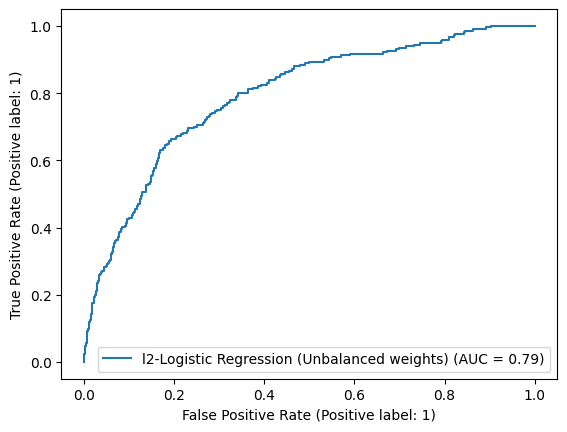

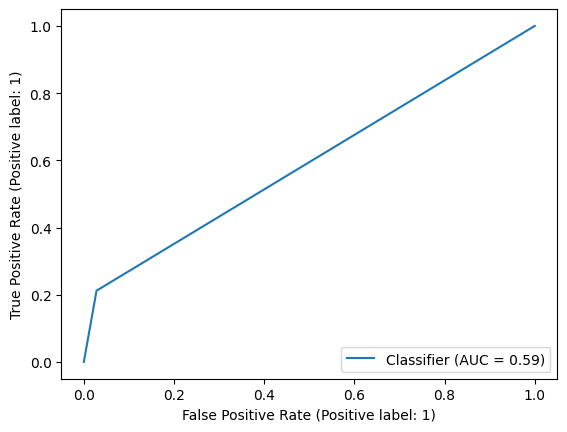

In [ ]:
print(balanced_accuracy_score(y_test,y_pred_balanced))
print(metrics.accuracy_score(y_test,y_pred_unbalanced))
print(classification_report(y_test,y_pred_unbalanced))
print(metrics.average_precision_score(y_test, y_pred_unbalanced))

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_unbalanced)
print(metrics.auc(fpr, tpr))
ax = plt.gca()
RocCurveDisplay.from_estimator(logistic_cv_unbalanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Unbalanced weights)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_unbalanced)

In [ ]:
np.mean(bal_accs)

0.7869890702166187

In [ ]:
y_train_pred = logistic_cv_balanced.predict(X_train)
metrics.balanced_accuracy_score(y_train, y_train_pred)

0.7551915694049023

#### Unbalanced

In [ ]:
print(np.mean(bal_accs))
print(np.mean(auc_scores))

0.6117478608461514
0.8394302064468324


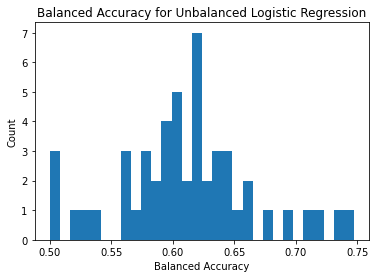

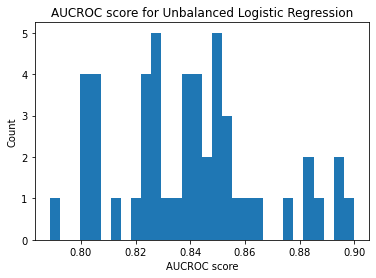

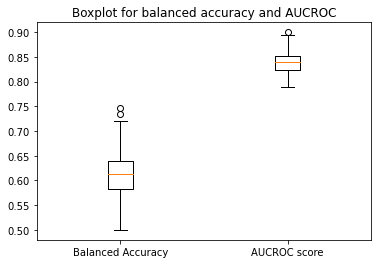

In [ ]:
plt.hist(bal_accs, bins = 30)
plt.title('Balanced Accuracy for Unbalanced Logistic Regression')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores, bins = 30)
plt.title('AUCROC score for Unbalanced Logistic Regression')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs, auc_scores])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

#### Balanced

In [ ]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.7685108236575676
0.839012440108896


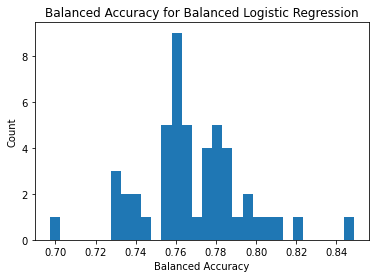

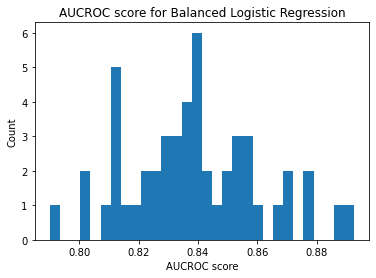

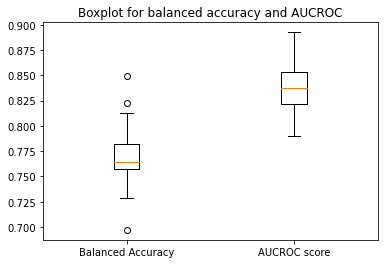

In [ ]:
plt.hist(bal_accs_w, bins = 30)
plt.title('Balanced Accuracy for Balanced Logistic Regression')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Count')
plt.show()

plt.hist(auc_scores_w, bins = 30)
plt.title('AUCROC score for Balanced Logistic Regression')
plt.xlabel('AUCROC score')
plt.ylabel('Count')
plt.show()


plt.boxplot([bal_accs_w, auc_scores_w])
plt.title('Boxplot for balanced accuracy and AUCROC')
plt.xticks([1, 2], ["Balanced Accuracy","AUCROC score"])
plt.show()

## pymc data with ridge regression

In [ ]:
df = pd.read_csv('pymc_data.csv')
df_1 = df.iloc[:100, :5]
df_1['outcome'] = df.iloc[:100, -6]
df_2 = df.iloc[100:200, :5]
df_2['outcome'] = df.iloc[100:200, -6]
df_3 = df.iloc[200:300, :5]
df_3['outcome'] = df.iloc[200:300, -6]
df_4 = df.iloc[300:, :5]
df_4['outcome'] = df.iloc[300:, -6]
df_list = [df_1, df_2, df_3, df_4]

In [ ]:
one_assay = df_list[0]
one_assay = one_assay.drop(one_assay.columns[0],axis=1)
scaler = StandardScaler().fit(one_assay.iloc[:,:4])
X = scaler.transform(one_assay.iloc[:,:4])
y = label_encoder.fit_transform(one_assay.iloc[:,4])
one_assay.iloc[:,4].value_counts()

0.0    50
1.0    50
Name: outcome, dtype: int64

0


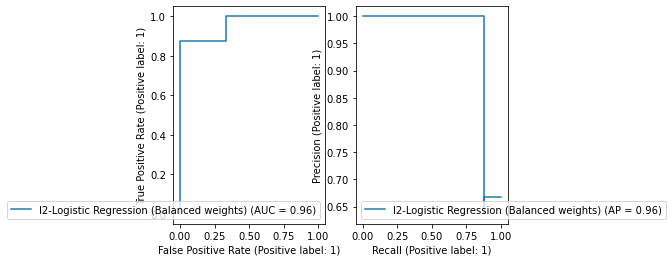

1


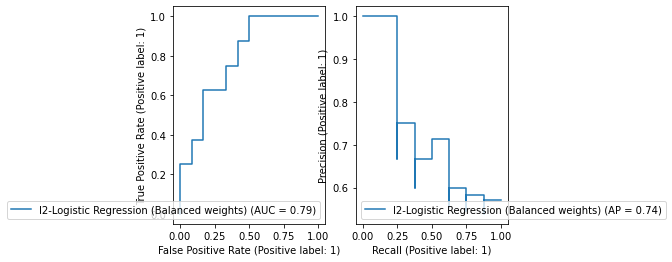

2


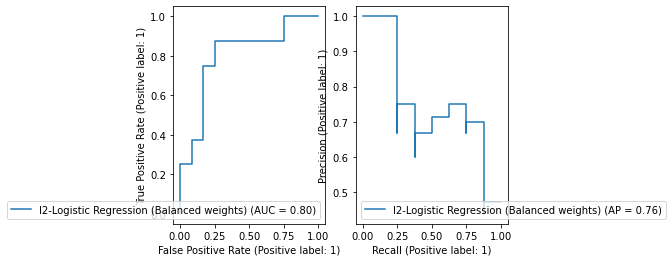

3


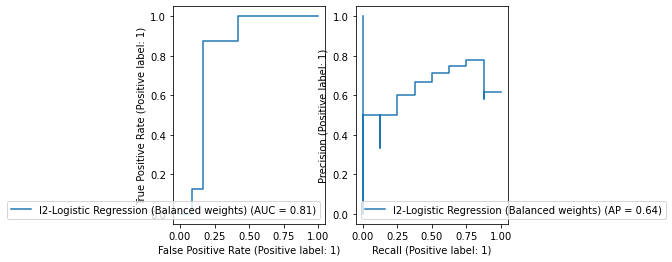

In [ ]:
label_encoder = preprocessing.LabelEncoder()

coefs_w = []

bal_accs_w = []

auc_scores_w = []
lambdas_ridge = []
for i in range(len(df_list)):
    one_assay = df_list[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1)
    scaler = StandardScaler().fit(one_assay.iloc[:,:4])
    X = scaler.transform(one_assay.iloc[:,:4])
    y = label_encoder.fit_transform(one_assay.iloc[:,4])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)
    logistic_cv_balanced = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced').fit(X_train, y_train)

    coef_w = logistic_cv_balanced.coef_[0]
    coefs_w.append(coef_w)

    y_pred_balanced = logistic_cv_balanced.predict(X_test)

    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    print(i)

    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc_w)

    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_scores_w.append(auc_score_w)

    lambda_rid = logistic_cv_balanced.C_
    lambdas_ridge.append(lambda_rid)

    fig, (ax, ax1) = plt.subplots(1,2)

    RocCurveDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax,name="l2-Logistic Regression (Balanced weights)")

    PrecisionRecallDisplay.from_estimator(logistic_cv_balanced, X_test, y_test,ax=ax1,name="l2-Logistic Regression (Balanced weights)")

    plt.show()


In [ ]:
print(np.mean(bal_accs_w))
print(np.mean(auc_scores_w))

0.78125
0.8411458333333334


In [ ]:
np.sqrt(logistic_cv_balanced.C_)

array([1.66810054])

In [ ]:
lambdas_ridge

[array([0.35938137]),
 array([0.00599484]),
 array([2.7825594]),
 array([2.7825594])]

In [ ]:
pd.DataFrame(lambda_sig_w).to_csv('log_reg_w_lambda_sig.csv', index=False)

## Lasso - test for irrelevant features across all assays

In [ ]:
import warnings
warnings.filterwarnings('ignore')
label_encoder = preprocessing.LabelEncoder()
coefs = []
coefs_w = []
bal_accs = []
bal_accs_w = []
auc_scores = []
auc_scores_w = []
lambda_sig_w = []

coef_df = []
coef_df_w = []

for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates()
    scaler = StandardScaler().fit(one_assay.iloc[:,2:])
    X = scaler.transform(one_assay.iloc[:,2:])
    y = label_encoder.fit_transform(one_assay.iloc[:,0])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    logistic_cv_unbalanced = LogisticRegressionCV(penalty='l1',class_weight=None, solver = 'saga').fit(X_train, y_train)
    logistic_cv_balanced = LogisticRegressionCV(penalty='l1',class_weight='balanced', solver = 'saga').fit(X_train, y_train)

    coef = logistic_cv_unbalanced.coef_[0]
    coef_u = pd.DataFrame({'features': list(one_assay.columns[2:]), 'coefs': list(coef)}, columns=['features', 'coefs'])
    coefs.append(coef)
    coef_df.append(coef_u)

    coef_w = logistic_cv_balanced.coef_[0]
    coef_w_df = pd.DataFrame({'features': list(one_assay.columns[2:]), 'coefs': list(coef_w)}, columns=['features', 'coefs'])
    coefs_w.append(coef_w)
    coef_df_w.append(coef_w_df)


    y_pred_unbalanced = logistic_cv_unbalanced.predict(X_test)
    y_pred_balanced = logistic_cv_balanced.predict(X_test)

    y_pred_prob = logistic_cv_unbalanced.predict_proba(X_test)[:,1]
    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    print(one_assay.columns[0])
    print(classification_report(y_test,y_pred_balanced))

    bal_acc = balanced_accuracy_score(y_test,y_pred_unbalanced)
    bal_accs.append(bal_acc)

    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_accs_w.append(bal_acc_w)

    auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc_score)

    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_scores_w.append(auc_score_w)

    lambda_sig = logistic_cv_balanced.C_
    lambda_sig_w.append(lambda_sig)
    print(i)



tox21-ahr-p1
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1423
           1       0.24      0.77      0.37       120

    accuracy                           0.80      1543
   macro avg       0.61      0.78      0.62      1543
weighted avg       0.92      0.80      0.84      1543

0
tox21-ap1-agonist-p1
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1397
           1       0.18      0.67      0.28        84

    accuracy                           0.81      1481
   macro avg       0.58      0.74      0.59      1481
weighted avg       0.93      0.81      0.85      1481

1
tox21-ar-bla-antagonist-p1
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1371
           1       0.26      0.72      0.38       156

    accuracy                           0.76      1527
   macro avg       0.61      0.74      0.62      1527
weighted 

tox21-hdac-p1
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1491
           1       0.12      0.70      0.21        27

    accuracy                           0.91      1518
   macro avg       0.56      0.81      0.58      1518
weighted avg       0.98      0.91      0.94      1518

24
tox21-hre-bla-agonist-p1
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1314
           1       0.21      0.62      0.32       128

    accuracy                           0.76      1442
   macro avg       0.58      0.70      0.59      1442
weighted avg       0.89      0.76      0.81      1442

25
tox21-hse-bla-p1
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1230
           1       0.21      0.72      0.33        78

    accuracy                           0.82      1308
   macro avg       0.59      0.77      0.61      1308
weighted avg

tox21-rt-viability-hepg2-p1
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1403
           1       0.14      0.67      0.23        85

    accuracy                           0.75      1488
   macro avg       0.56      0.71      0.54      1488
weighted avg       0.93      0.75      0.81      1488

48
tox21-rt-viability-hek293-p1
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1192
           1       0.42      0.77      0.54       243

    accuracy                           0.78      1435
   macro avg       0.68      0.78      0.70      1435
weighted avg       0.86      0.78      0.80      1435

49


In [ ]:
fea_0 = []
fea_0_un = []
for i in range(len(coef_df_w)):
    co = list(coef_df_w[i][coef_df_w[i].coefs==0].features)
    co_un = list(coef_df[i][coef_df[i].coefs==0].features)
    if co != None:
        fea_0.append(co)
        fea_0_un.append(co_un)

len(fea_0)

50

204


(array([ 2.,  0., 43.,  0.,  0., 37.,  0., 30.,  0.,  0., 37.,  0., 23.,
         0.,  0., 28.,  0.,  2.,  0.,  2.]),
 array([ 3. ,  3.4,  3.8,  4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,
         7.4,  7.8,  8.2,  8.6,  9. ,  9.4,  9.8, 10.2, 10.6, 11. ]),
 <BarContainer object of 20 artists>)

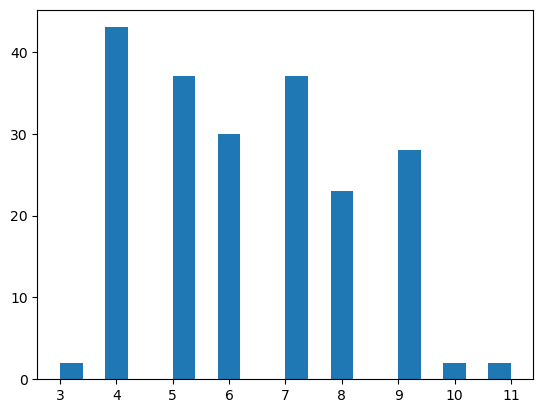

In [ ]:
flat_list = [item for sublist in fea_0 for item in sublist]
flat_list = pd.DataFrame(flat_list, columns=['features'])
print(len(flat_list.features.value_counts()))
plt.hist(flat_list.features.value_counts(), bins=20)

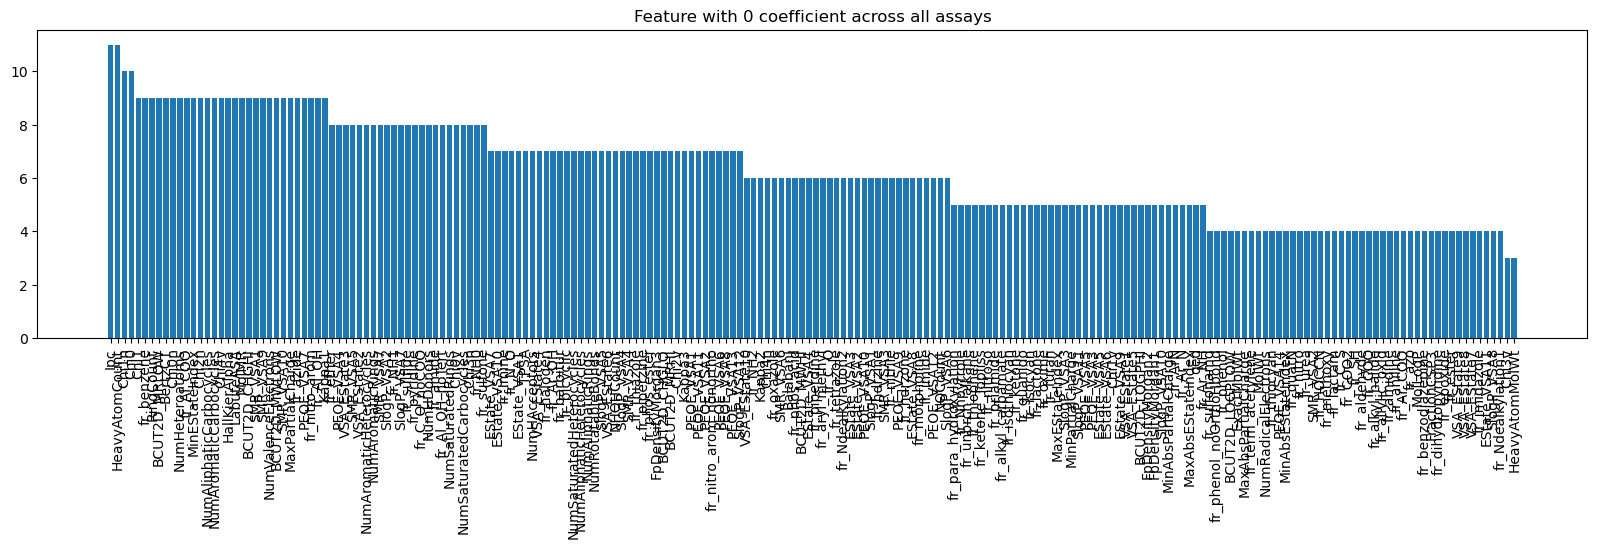

In [ ]:
flat_list_un = [item for sublist in fea_0_un for item in sublist]
flat_list_un = pd.DataFrame(flat_list_un, columns=['features'])
feature_select = pd.DataFrame(flat_list.features.value_counts())
fig, ax = plt.subplots(figsize=(20,4))
plt.bar(feature_select.index, height = feature_select.features)
plt.xticks(rotation=90)
plt.title('Feature with 0 coefficient across all assays')
plt.savefig("feautes_with_0_coef.png",bbox_inches='tight')

In [ ]:
feature_select[feature_select.features<=4]

,features
fr_sulfonamd,4
fr_phenol_noOrthoHbond,4
fr_phenol,4
BCUT2D_LOGPLOW,4
ExactMolWt,4
MaxAbsPartialCharge,4
fr_term_acetylene,4
MolWt,4
NumRadicalElectrons,4
fr_thiocyan,4
